<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Studies and Trials

Aggregates and displays studies and trials found in a optuna database 

**Overview of all Studies**
* trial states and hyperparam distribution settings
* visualization of best trials

**Study Details**
* parallel plot of hyperparameters
* hyperparameter importance
* evaluation metrics plots
* training progress

In [438]:
!pip install -q --upgrade optuna >/dev/null

In [439]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt

## Connect Google Drive

In [440]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Database Connection

In [441]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Show all Studies

In [442]:
for s in optuna.get_all_study_summaries(storage):
    start = "???" if s.datetime_start is None else s.datetime_start.date()
    print(f"{str(start):>10} {s.n_trials:>4} trials '{s.study_name}'")

2021-12-18   70 trials 'distilbert-base-german-cased_bs32'
2021-12-20  171 trials 'distilbert-base-german-cased_multi_mcc'
2021-12-21  103 trials 'distilbert-base-german-cased_epoch2'
2021-12-23   29 trials 'deepset/gbert-base_bs16_epoch234'
2021-12-27  133 trials 'deepset/gbert-base_loss-mcc_bs16_epoch234'
2022-01-01  149 trials 'deepset/gelectra-base_loss-f1_bs16_epoch234'
2022-01-05  289 trials 'distilbert-base-german-cased_loss-f1_bs32_epoch23'
2022-01-08   83 trials 'distilbert-base-german-cased_loss-f1_bs32_epoch1'
2022-01-08   95 trials 'deepset/gbert-base_loss-f1_bs32_epoch1'
2022-01-09   16 trials 'deepset/gbert-base_loss-f1_bs16_epoch23'


## Study Information

In [443]:
study_info = []
study_states = []
study_dist = []

def dist2str(dist: optuna.distributions.BaseDistribution) -> str:
    if isinstance(dist, optuna.distributions.UniformDistribution):
        return f"{dist.low} -> {dist.high}"
    if isinstance(dist, optuna.distributions.LogUniformDistribution):
        return f"{dist.low} -> {dist.high} (log)"
    if isinstance(dist, optuna.distributions.CategoricalDistribution):
        return f"{dist.choices}"
    else:
        return str(dist)

for s in optuna.get_all_study_summaries(storage):
    name = s.study_name
    info = {"study_name": name,
            "start": "???" if s.datetime_start is None else s.datetime_start.date(),
            "directions": len(s.directions)}
    study_info.append(info)

    study = optuna.load_study(name, storage)
    states = pd.Series([t.state for t in study.get_trials()]).value_counts()
    counts = {str(state).split(".")[1]:count for state, count in states.items()}
    study_states.append(counts)

    dist = study.get_trials()[0].distributions
    dist = {k:dist2str(dist[k]) for k in dist.keys()}
    study_dist.append(dist)

pd.concat([pd.DataFrame(study_info),
           pd.DataFrame(study_states).fillna(0).astype(int),
           pd.DataFrame(study_dist),], axis=1).fillna("--")

,study_name,start,directions,COMPLETE,FAIL,PRUNED,RUNNING,label_smoothing_factor,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
0,distilbert-base-german-cased_bs32,2021-12-18,1,70,0,0,0,0.0 -> 0.1,1e-05 -> 0.0001 (log),"(1,)","(32,)",0.001 -> 0.01 (log)
1,distilbert-base-german-cased_multi_mcc,2021-12-20,2,170,1,0,0,--,1e-05 -> 0.0001 (log),"(1,)","(16, 32)",0.001 -> 0.01 (log)
2,distilbert-base-german-cased_epoch2,2021-12-21,1,100,3,0,0,0.0 -> 0.1,1e-05 -> 0.0001 (log),"(2,)","(8, 16, 32)",0.001 -> 0.01 (log)
3,deepset/gbert-base_bs16_epoch234,2021-12-23,1,22,1,3,3,--,1e-05 -> 0.0001 (log),"(2, 3, 4)","(16,)",0.001 -> 0.01 (log)
4,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-27,2,124,3,0,6,--,1e-05 -> 0.0001 (log),"(2, 3, 4)","(16,)",0.001 -> 0.01 (log)
5,deepset/gelectra-base_loss-f1_bs16_epoch234,2022-01-01,2,141,2,0,6,--,6e-05 -> 0.0002 (log),"(2, 3)","(16,)",0.001 -> 0.01 (log)
6,distilbert-base-german-cased_loss-f1_bs32_epoch23,2022-01-05,2,237,15,25,12,--,3e-05 -> 0.0001 (log),"(2, 3)","(32,)","(0.001, 0.0)"
7,distilbert-base-german-cased_loss-f1_bs32_epoch1,2022-01-08,2,47,3,30,3,--,3e-05 -> 0.0001 (log),"(1,)","(32,)",0.001 -> 0.01 (log)
8,deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-08,2,63,3,27,2,--,3e-05 -> 0.0001 (log),"(1,)","(16,)",0.001 -> 0.01 (log)
9,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,2,12,1,2,1,--,1e-05 -> 0.0001 (log),"(2, 3)","(16,)",0.001 -> 0.01 (log)


## Best Results of Studies

In [444]:
stats = []
attrs = []
params = []
for s in optuna.get_all_study_summaries(storage):
    study = optuna.load_study(s.study_name, storage)
    for i, t in enumerate(study.best_trials):
        stats.append({"study_name": s.study_name,
                      "start": t.datetime_start.date(),
                    #   "best_count": i+1,
                      "trial_number": t.number,
                      })
        ua = t.user_attrs
        if "eval_result" in ua.keys():
            ua = ua["eval_result"]
        attrs.append(ua)
        params.append(t.params)

best_trials_df = pd.concat([pd.DataFrame(stats),
                            pd.DataFrame(attrs),
                            pd.DataFrame(params)], axis=1)
best_trials_df.drop(inplace=True, columns = [c for c in best_trials_df.columns if "per_second" in c])
best_trials_df.drop(inplace=True, columns = ["epoch"])
best_trials_df.rename(inplace=True, columns = {"num_train_epochs": "epochs",
                                               "per_device_train_batch_size": "bs"})
best_trials_df.sort_values(["study_name", "eval_loss"])

,study_name,start,trial_number,eval_acc,eval_f1,eval_loss,eval_precision,eval_recall,eval_runtime,eval_mcc,label_smoothing_factor,learning_rate,epochs,bs,weight_decay
9,deepset/gbert-base_bs16_epoch234,2021-12-27,21,0.903696,0.897792,0.316875,0.898731,0.898682,19.6023,0.889813,NaN,0.000023,2,16,0.002689
52,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,5,0.911479,0.909600,0.302235,0.910222,0.909650,19.7397,0.898701,NaN,0.000019,3,16,0.001217
51,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,3,0.911479,0.911428,0.312597,0.911844,0.911582,19.7429,0.898648,NaN,0.000025,3,16,0.001816
53,deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,7,0.912451,0.911521,0.318797,0.913340,0.910824,19.7097,0.899798,NaN,0.000028,3,16,0.009014
45,deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-08,0,0.907588,0.903246,0.300927,0.904264,0.902778,19.6790,0.894202,NaN,0.000032,1,16,0.007113
49,deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-09,82,0.907588,0.904215,0.301083,0.903684,0.905506,19.8736,0.894269,NaN,0.000033,1,16,0.005332
50,deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-09,83,0.907588,0.904833,0.301115,0.904899,0.905506,19.7579,0.894263,NaN,0.000033,1,16,0.008506
47,deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-09,60,0.908560,0.905693,0.302753,0.905957,0.906242,19.8092,0.895399,NaN,0.000033,1,16,0.005332
48,deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-09,79,0.908560,0.905693,0.302753,0.905957,0.906242,19.8274,0.895399,NaN,0.000033,1,16,0.005332
46,deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-09,30,0.906615,0.905739,0.308460,0.903296,0.909381,19.7828,0.893228,NaN,0.000084,1,16,0.001171


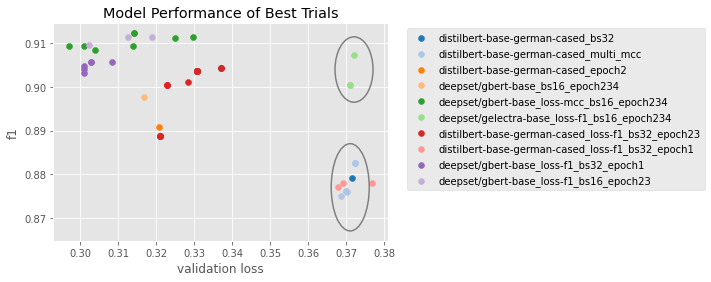

In [501]:
from matplotlib.patches import Ellipse
import seaborn as sns
pal = sns.color_palette("tab20", 10)

for i, s in enumerate(best_trials_df.study_name.unique()):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.eval_loss, df.eval_f1, label=s, color=pal[i%10])


ax = plt.gca()
ax.add_patch(Ellipse(xy=(0.371, 0.877), width=0.01, height=0.02, edgecolor='gray', fc='None', lw=1.5))
ax.add_patch(Ellipse(xy=(0.372, 0.904), width=0.01, height=0.015, edgecolor='gray', fc='None', lw=1.5))

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("validation loss")
plt.ylabel("f1")
plt.title("Model Performance of Best Trials");

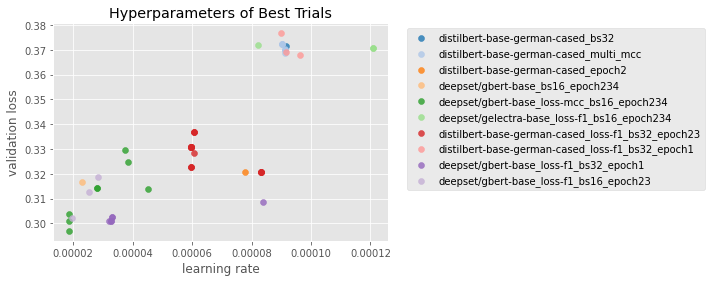

In [505]:
for i, s in enumerate(best_trials_df.study_name.unique()):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.learning_rate, df.eval_loss, label=s, color=pal[i%10], alpha=0.8)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("learning rate")
plt.ylabel("validation loss")
plt.title("Hyperparameters of Best Trials");

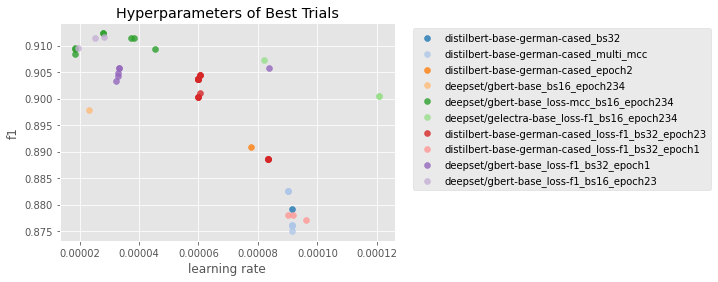

In [506]:
for i, s in enumerate(best_trials_df.study_name.unique()):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.learning_rate, df.eval_f1, label=s, color=pal[i%10], alpha=0.8)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("learning rate")
plt.ylabel("f1")
plt.title("Hyperparameters of Best Trials");

In [446]:
# optuna.delete_study('deepset/gbert-base_bs16_epoch234', storage)
[s.study_name for s in optuna.get_all_study_summaries(storage)]

['distilbert-base-german-cased_bs32',
 'distilbert-base-german-cased_multi_mcc',
 'distilbert-base-german-cased_epoch2',
 'deepset/gbert-base_bs16_epoch234',
 'deepset/gbert-base_loss-mcc_bs16_epoch234',
 'deepset/gelectra-base_loss-f1_bs16_epoch234',
 'distilbert-base-german-cased_loss-f1_bs32_epoch23',
 'distilbert-base-german-cased_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs16_epoch23']

## Load Study

In [484]:
# study = optuna.load_study('distilbert-base-german-cased_epoch2', storage)
# study = optuna.load_study('distilbert-base-german-cased_multi_mcc', storage)
# study = optuna.load_study('deepset/gbert-base_loss-mcc_bs16_epoch234', storage)
# study = optuna.load_study('deepset/gelectra-base_loss-f1_bs16_epoch234', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch23', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch1', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs32_epoch1', storage)
study = optuna.load_study('deepset/gbert-base_loss-f1_bs16_epoch23', storage)

## Analyze Zombie Trials

Interupted trials left in RUNNING state.

In [485]:
from optuna.trial import TrialState

running_trials = study.get_trials(states=[TrialState.RUNNING])

pd.DataFrame([t.params for t in running_trials])

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
0,0.00006,2,16,0.001175


## Analyze Complete Trials

In [486]:
from optuna.trial import TrialState

complete_trials = study.get_trials(states=[TrialState.COMPLETE])

In [487]:
def get_metrics(trial):
    attrs = trial.user_attrs
    if "eval_result" in attrs.keys():
        attrs = attrs["eval_result"]
    return attrs

# create DataFrames
if len(complete_trials) > 0:
    index = [t.number for t in complete_trials]
    trial_metrics_df = pd.DataFrame([get_metrics(t) for t in complete_trials], index=index)
    trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
    trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss", ascending=True)
    best = [t.number for t in study.best_trials]
    trial_df["best"] = trial_df.index.isin(best)
    main_metric = "eval_loss"
    trial_params_df[main_metric] = trial_metrics_df[main_metric]
    display(trial_df.head(10))

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,best
5,0.000019,3,16,0.001217,0.302235,0.911479,0.909600,0.910222,0.909650,0.898701,19.7397,52.078,3.293,3.0,True
12,0.000011,3,16,0.009083,0.309182,0.904669,0.901743,0.904330,0.899859,0.890873,19.7312,52.100,3.294,3.0,False
3,0.000025,3,16,0.001816,0.312597,0.911479,0.911428,0.911844,0.911582,0.898648,19.7429,52.069,3.292,3.0,True
7,0.000028,3,16,0.009014,0.318797,0.912451,0.911521,0.913340,0.910824,0.899798,19.7097,52.157,3.298,3.0,True
6,0.000023,2,16,0.001644,0.319293,0.906615,0.903560,0.903944,0.903997,0.893095,19.7642,52.013,3.289,2.0,False
15,0.000029,2,16,0.001480,0.320579,0.908560,0.906044,0.906220,0.906923,0.895328,19.7642,52.013,3.289,2.0,False
1,0.000048,2,16,0.009566,0.327018,0.893969,0.893994,0.896787,0.891618,0.878511,19.7010,52.180,3.299,2.0,False
10,0.000060,2,16,0.006362,0.329289,0.900778,0.896709,0.895718,0.898568,0.886418,19.6787,52.239,3.303,2.0,False
2,0.000067,2,16,0.001210,0.337582,0.907588,0.902066,0.899982,0.904906,0.894229,19.6683,52.267,3.305,2.0,False
9,0.000098,2,16,0.002499,0.340434,0.905642,0.901607,0.900663,0.903091,0.891943,19.8682,51.741,3.272,2.0,False


In [488]:
import plotly.express as px

fig = px.parallel_coordinates(trial_df[trial_params_df.columns], color=main_metric, 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.update_layout(autosize=False, width=700, height=350)
fig.show()

In [489]:
# fig = optuna.visualization.plot_parallel_coordinate(study, target=lambda trial: trial.user_attrs["eval_loss"], target_name="loss")
# fig.update_layout(autosize=False, width=700, height=350)
# fig.show()

In [490]:
# optuna.visualization.plot_contour(study)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



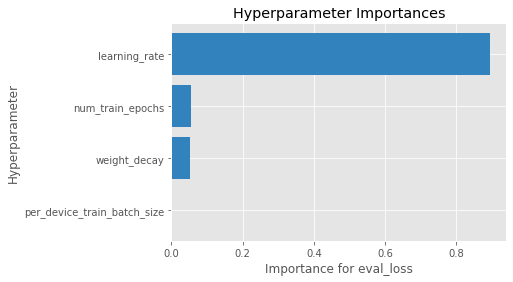

In [491]:
# from optuna.visualization import plot_param_importances
from optuna.visualization.matplotlib import plot_param_importances

fig = plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)
# fig.update_layout(autosize=False, width=800, height=350)
# fig.show()

In [492]:
def get_loss(trial):
    """Handle different data format versions"""
    if "eval_result" in trial.user_attrs.keys():
        return trial.user_attrs["eval_result"]["eval_loss"]
    else:
        return trial.user_attrs["eval_loss"]

In [493]:
fig = optuna.visualization.plot_slice(study, target=get_loss, target_name="loss")
fig.update_layout(autosize=False, width=900, height=350)
fig.show()

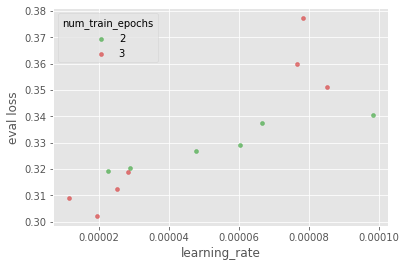

In [494]:
import seaborn as sns

pal = sns.color_palette("tab10", 10)

# plt.scatter(trial_df.eval_loss, trial_df.learning_rate, c=trial_df.best, cmap="Set1_r", alpha=0.6, s=8);
field = "num_train_epochs"
for f in sorted(trial_df[field].unique()):
    df = trial_df[lambda x: x[field] == f]
    plt.scatter(df.learning_rate, df.eval_loss, alpha=0.6, s=16, label=f, color=pal[f])

# plt.gca().set_xscale('log')
plt.legend(title=field)
plt.ylabel("eval loss")
plt.xlabel("learning_rate");

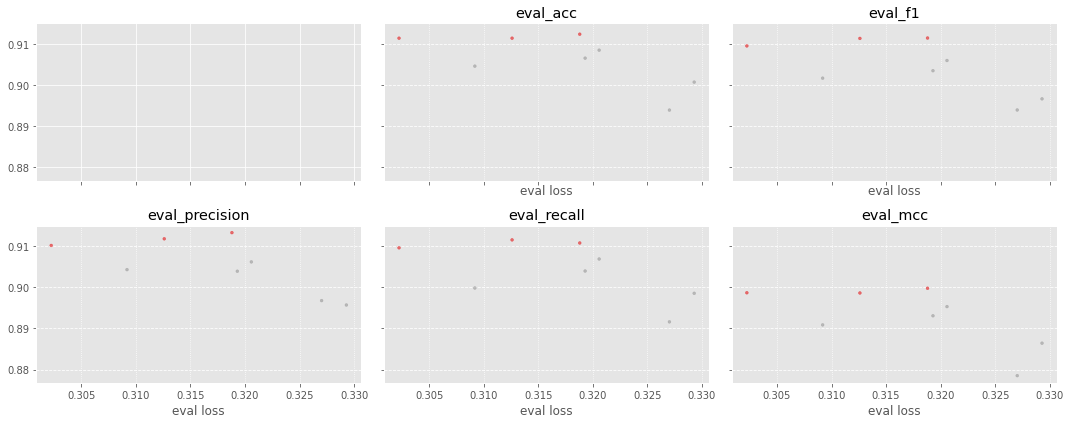

In [495]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
metrics = [m for m in trial_metrics_df.columns if m not in exclude]

# only focus on low loss trials
loss_df = trial_df[lambda x: x.eval_loss < x.eval_loss.mean()]

for col, ax in zip(metrics, axs.flatten()):
    if col == "eval_loss":
        continue
    ax.scatter(loss_df.eval_loss, loss_df[col], c=loss_df.best, cmap="Set1_r", alpha=0.6, s=8);
    ax.set_title(col)
    ax.set_xlabel("eval loss")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

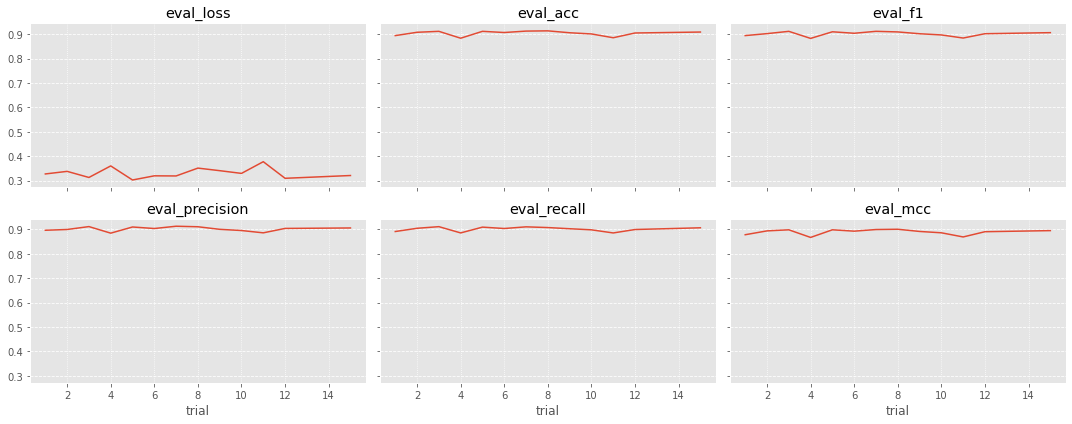

In [496]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

for col, ax in zip(metrics, axs.flatten()):
    trial_df[col].sort_index().plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel("trial")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Single Trial - Extract data logged during train

In [497]:
running_trials = [t for t in study.get_trials() if t.state==TrialState.RUNNING]
data = complete_trials[-1].user_attrs
if "eval_result" in data.keys():
    log_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    log_df.index = log_df.index.astype(int)
    log_df.sort_index(inplace=True)
    display(log_df)

,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,lr
115,0.479013,0.855058,0.844724,0.853318,0.848051,0.834891,19.7550,52.037,3.290,0.20,2.617618e-05
230,0.394284,0.869650,0.869446,0.869789,0.872276,0.851165,19.7621,52.019,3.289,0.40,2.328448e-05
345,0.386907,0.877432,0.871754,0.874797,0.881300,0.861002,19.7471,52.058,3.292,0.60,2.039278e-05
460,0.423146,0.871595,0.871859,0.883692,0.873430,0.854980,19.7539,52.040,3.290,0.80,1.750108e-05
575,0.329232,0.899805,0.895886,0.900156,0.892853,0.885292,19.7952,51.932,3.284,0.99,1.460938e-05
690,0.338937,0.896887,0.894954,0.896362,0.895862,0.882275,19.8025,51.913,3.282,1.19,1.171768e-05
805,0.331358,0.900778,0.895720,0.896077,0.897540,0.886436,19.7820,51.966,3.286,1.39,8.825976e-06
920,0.333055,0.904669,0.902852,0.903411,0.903578,0.890948,19.7392,52.079,3.293,1.59,5.934274e-06
1035,0.330237,0.904669,0.902939,0.901965,0.905547,0.891013,19.7983,51.924,3.283,1.79,3.042573e-06
1150,0.320579,0.908560,0.906044,0.906220,0.906923,0.895328,19.7747,51.986,3.287,1.99,1.508714e-07


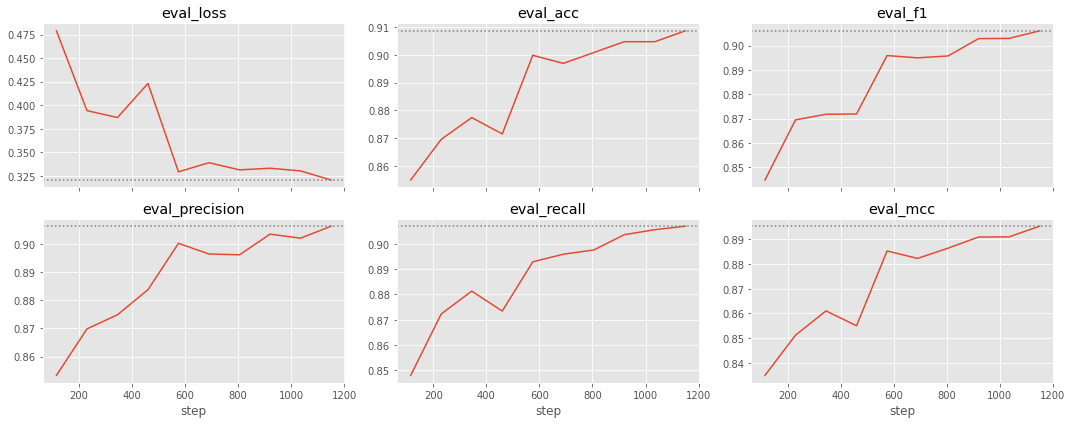

In [498]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True)

for col, ax in zip(metrics, axs.flatten()):
    log_df[col][0:-1].plot(ax=ax).axhline(log_df[col].values[-1], c="grey", linestyle=":")
    ax.set_title(col)
    ax.set_xlabel("step")
    # ax.grid(axis='y', linestyle='--', zorder=1)
    # ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Plot Learning Rate

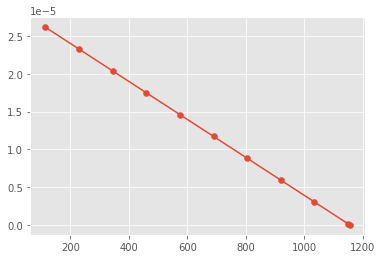

In [499]:
log_df["lr"].plot()
plt.scatter(log_df["lr"].index, log_df["lr"]);

# Plot all Loss Curves

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



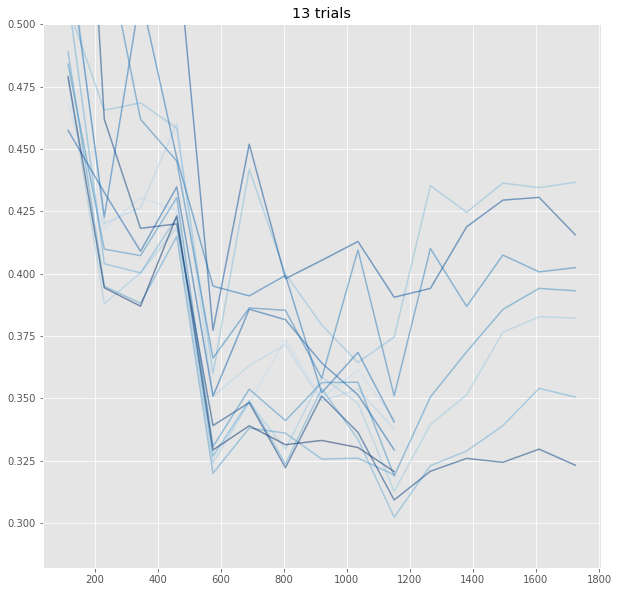

In [500]:
# https://stackoverflow.com/questions/52758070/color-map-to-shades-of-blue-python
# https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,10))

n = len(complete_trials)
colors = plt.cm.Blues(np.linspace(0.25,1,n))

count = 0
for i, t in enumerate(complete_trials):
    if not "eval_result" in t.user_attrs.keys():
        continue
    count += 1
    data = t.user_attrs
    loss_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    loss_df.index = loss_df.index.astype(int)
    loss_df.sort_index(inplace=True)
    ax.plot(loss_df["eval_loss"][0:-1], c=colors[i], alpha=0.5)
    # loss_df["eval_loss"].plot(ax=ax, cmap="Blues")
    # print(t.number, loss_df["eval_loss"])
plt.ylim([None,0.5])
plt.title(f"{count} trials");